# Laplacian of Gaussian
---

In [1]:
from skimage.feature import blob_log
blob_log?

Signature:
blob_log(
    image,
    min_sigma=1,
    max_sigma=50,
    num_sigma=10,
    threshold=0.2,
    overlap=0.5,
    log_scale=False,
)
Docstring:
Finds blobs in the given grayscale image.

Blobs are found using the Laplacian of Gaussian (LoG) method [1]_.
For each blob found, the method returns its coordinates and the standard
deviation of the Gaussian kernel that detected the blob.

Parameters
----------
image : 2D or 3D ndarray
    Input grayscale image, blobs are assumed to be light on dark
    background (white on black).
min_sigma : float, optional
    The minimum standard deviation for Gaussian Kernel. Keep this low to
    detect smaller blobs.
max_sigma : float, optional
    The maximum standard deviation for Gaussian Kernel. Keep this high to
    detect larger blobs.
num_sigma : int, optional
    The number of intermediate values of standard deviations to consider
    between `min_sigma` and `max_sigma`.
threshold : float, optional.
    The absolute lower bound for sca

In [2]:
from itertools import product

import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from shapely.geometry import box
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
plt.set_cmap('magma'); plt.close()

from skimage.measure import regionprops
from skimage.feature import canny
from skimage.segmentation import clear_border, felzenszwalb
from skimage.color import hed_from_rgb

import secdetect

## Process overview image
---

In [65]:
# Load random overview image from `secdetect.data`
imin = secdetect.data.load(12)
imec = secdetect.enhance_contrast(imin, channel=2, conv_matrix=hed_from_rgb)
imcn = canny(imec, sigma=4, low_threshold=0.10, high_threshold=0.99, use_quantiles=True)
cx, cy, r = secdetect.find_ring(imcn)
imcr = secdetect.crop_to_ring(imin, cx=cx, cy=cy, radius=r)
imeccr = secdetect.crop_to_ring(imec, cx=cx, cy=cy, radius=r)

imfz = felzenszwalb(imcr, scale=750, sigma=1, min_size=500, multichannel=True)
imcb = clear_border(imfz, buffer_size=50)
mask = imcb > 0

masked = np.where(mask, imeccr, 0)

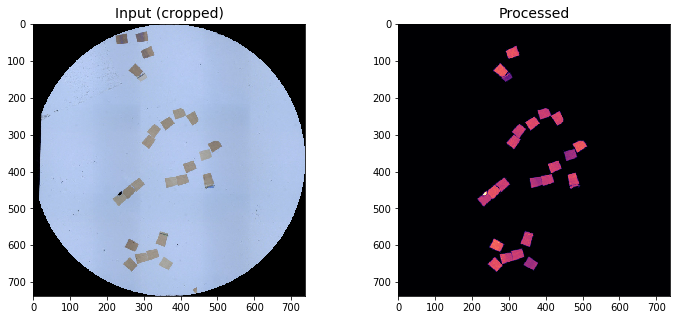

In [66]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
axes[0].imshow(imcr)
axes[1].imshow(masked)
axes[0].set_title('Input (cropped)', fontsize=14)
axes[1].set_title('Processed', fontsize=14);

## Iterate through parameter space
---

In [67]:
def product_dict(**kwargs):
    keys = kwargs.keys()
    vals = kwargs.values()
    for instance in product(*vals):
        yield dict(zip(keys, instance))

In [68]:
def blobs2bboxes(blobs, q=2):
    bboxes = []
    for blob in blobs:
        y, x, sig = blob
        r = np.sqrt(q) * sig
        bbox = box(minx=x-r,
                   miny=y-r,
                   maxx=x+r,
                   maxy=y+r)
        bboxes.append(bbox)
    return bboxes

In [69]:
LoG_param_set = {
    'min_sigma': [5, 10],
    'max_sigma': [10, 15],
    'num_sigma': [2, 5],
    'threshold': [0.05, 0.1],
    'overlap': [0.1, 0.5],
    'log_scale': [False],
}

LoG_param_space = list(product_dict(**LoG_param_set))

print(f'{len(LoG_param_space)} permutations')

32 permutations


In [70]:
columns = list(LoG_param_set.keys()) + ['blobs', 'bboxes']
df = pd.DataFrame(columns=columns)

i = 0 
for LoG_params in tqdm_notebook(LoG_param_space):
    
    # Blob analysis
    blobs = blob_log(masked, **LoG_params)
    
    # Build up DataFrame
    df = df.append(pd.DataFrame(LoG_params, index=[i]), sort=True)
    df.at[i, 'blobs'] = blobs
    df.at[i, 'bboxes'] = blobs2bboxes(blobs, q=2)
    
    # Increment index
    i += 1

# Preview DataFrame
df = df[columns]
df.drop(columns=['blobs', 'bboxes']).sample(5)

,min_sigma,max_sigma,num_sigma,threshold,overlap,log_scale
0,5,10,2,0.05,0.1,False
21,10,10,5,0.05,0.5,False
5,5,10,5,0.05,0.5,False
13,5,15,5,0.05,0.5,False
22,10,10,5,0.10,0.1,False


## Analysis
---

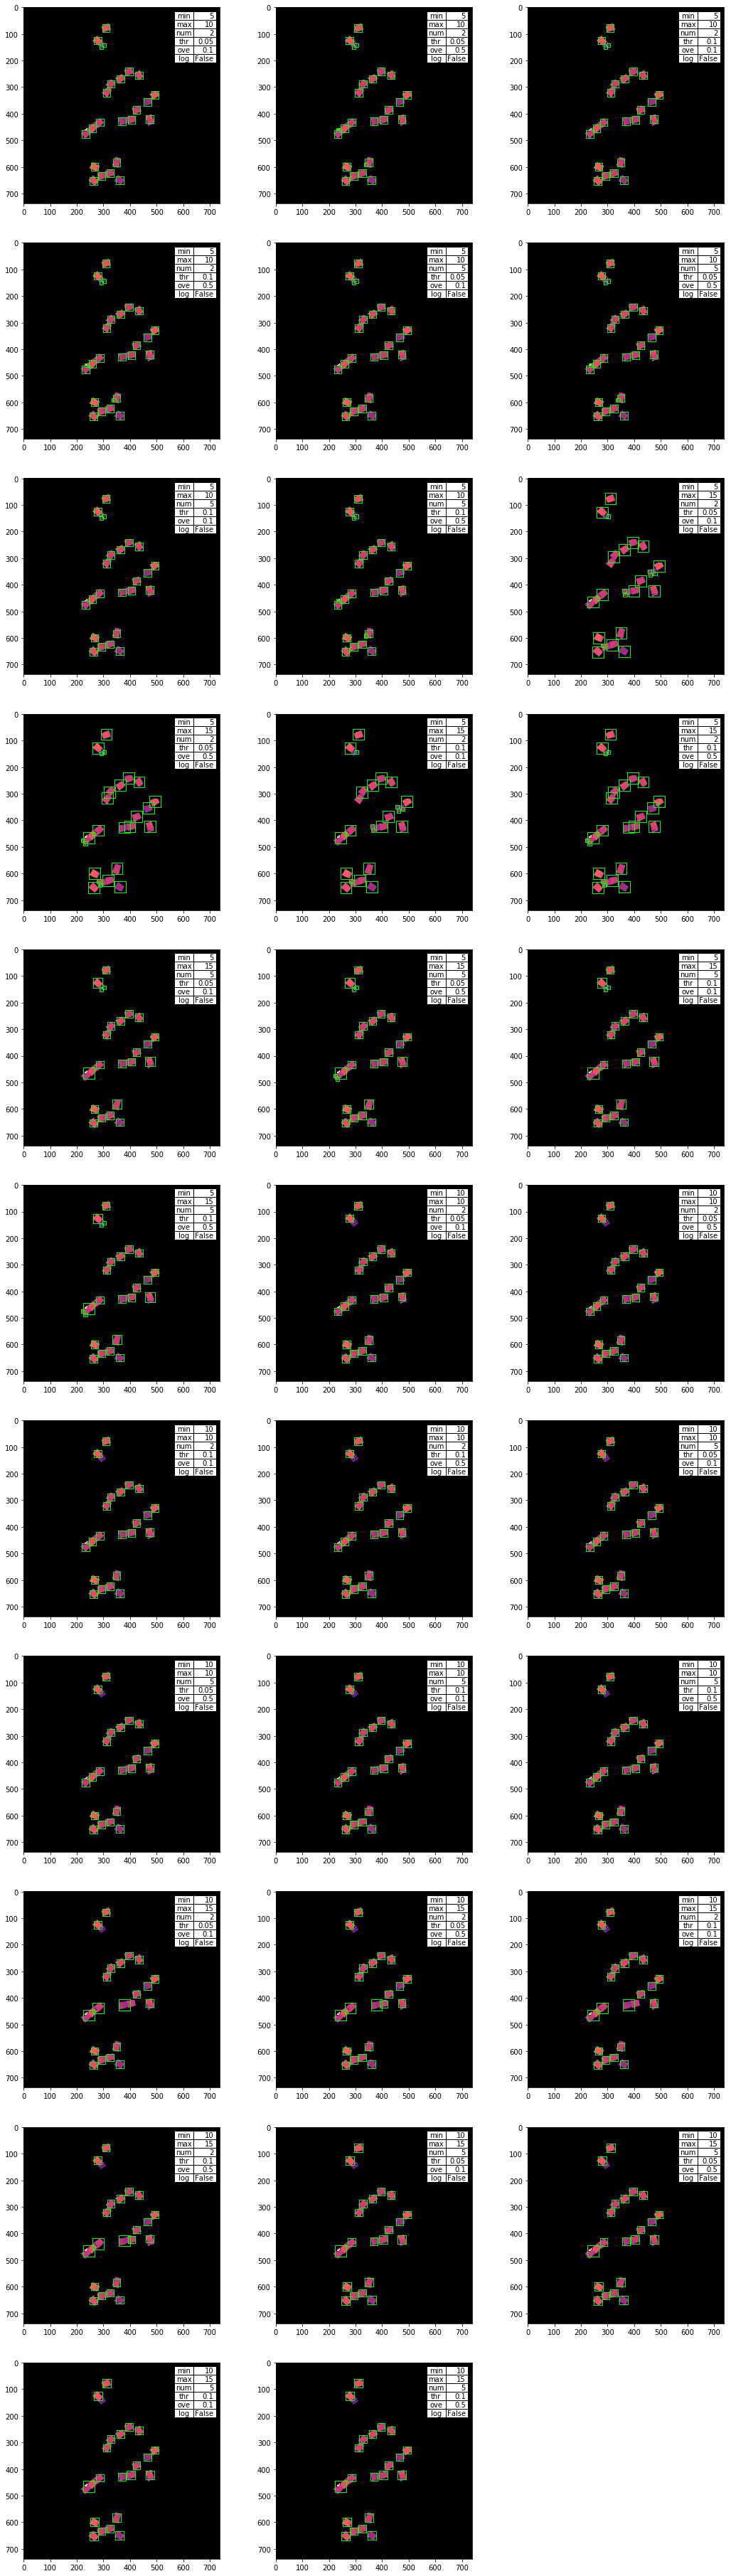

In [71]:
ncols = 3
nrows = int(np.ceil(len(df) / ncols))
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols, 6*nrows))
axes = axes.ravel()

for i, row in df.iterrows():
    
    # Plot image
    axes[i].imshow(masked)
    
    # Plot detected blobs
    for p in row['bboxes']:
        axes[i].plot(*p.exterior.xy, color='#00ff00', lw=1)
    
    # Make table
    vals = row.drop(index=['blobs', 'bboxes']).values[:, np.newaxis]
    cols = [col[:3] for col in row.drop(index=['blobs', 'bboxes']).index.tolist()]
    tab = axes[i].table(cellText=vals, rowLabels=cols,
                        rowLoc='center', loc='upper right',
                        zorder=1)
    tab.auto_set_column_width(0)

# Remove empty axes from fig
num = axes.size - len(df)  # num of empty axes
[fig.delaxes(ax) for ax in axes[-num:] if num > 0];